# Tarea 3 : Detección de neumonías a partir de imágenes de rayos X
## Aprendizaje Automático I
### Esteban Reyes Saldaña

**Descripción**. Implementar una red neuronal basada en la estrategia de transferencia de conocimiento (http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/preentrenadas/preentrenadas.html) para resolver el el problema de clasificación de neumonías presentado en Kaggle (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). Use la red preentrenada de su elección.

# Resumen

En esta tarea se utilizaron diferentes redes pre-entrenadas cargadas en la libería de keras para usar **transferencia de conocimiento** a imágenes de **neuomonía**. Se hicieron pruebas usando diferentes arquitecturas y distintos generadores de datos. A continuación se muestran los resultados obtenidos así como algunas gráficas del comportamiento de la *exactitud* y la *pérdida*. Los mejores pesos (con respecto a la exactitud en el conjunto de validación) se guardaron en una carpeta de Drive.

In [ ]:
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
import cv2
import os
%matplotlib inline  

Versión de Keras a utilizar

In [ ]:
keras.__version__

'2.4.3'

Compruebo disponibilidad de GPU

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4770515793647562011
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13627203195190407266
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


# Un vistazo a los datos

Cargo datos de entrenamiento

In [ ]:
base_dir        = '../content/drive/MyDrive/CIMAT/Segundo Semestre/Aprendizaje Profundo/Tarea3/chest_xray/'
train_pneumonia = os.listdir(base_dir + 'train/PNEUMONIA')
train_normal    = os.listdir(base_dir + 'train/NORMAL/')

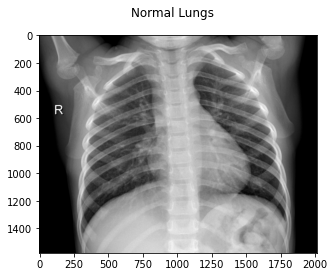

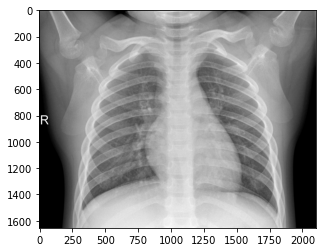

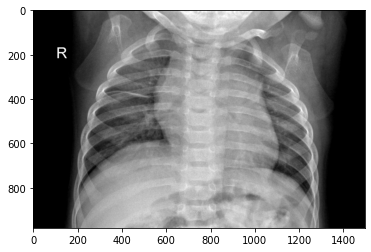

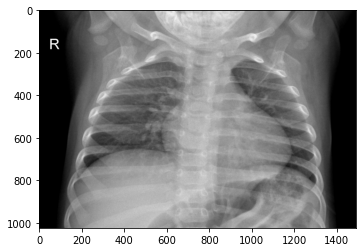

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img

plt.suptitle('Normal Lungs')
for i in range(0,4):
    img = train_normal[i]
    img = load_img(base_dir + 'train/NORMAL/' + img)
    plt.imshow(img)
    plt.show()

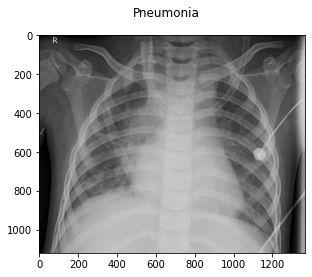

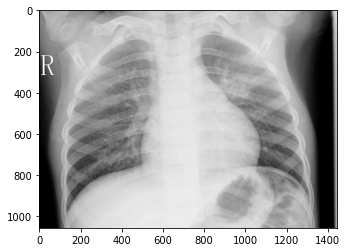

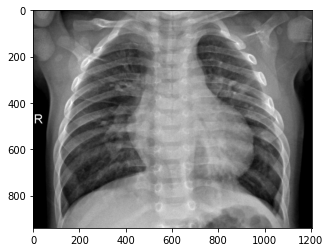

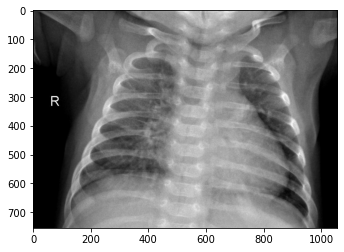

In [ ]:
plt.suptitle('Pneumonia')
for i in range(0,4):
    img = train_pneumonia[i]
    img = load_img(base_dir + 'train/PNEUMONIA/' + img)
    plt.imshow(img)
    plt.show()

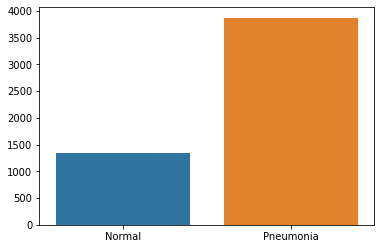

In [ ]:
sns.barplot(x=['Normal','Pneumonia'],y=[len(train_normal),len(train_pneumonia)])

# Transferencia de Conocimiento

Una estrategia para lidiar en redes neuronales profundas es usar redes previamente preentrenadas con bases de datos grandes y adaptarlas al problema de nuestro interés.

Para este propósito es necesario que la red preentrenada haya sido entrenada para resolver un problema de carácter mas general, del que nuestro problema se pueda consider un caso particular. 

# Red VGG16

Esta red fue entrenada para clasificar perros y gatos (Symonyan and Zisserman, 2015). Algunas de sus características son


*   Tiene una arquitectura fácil de comprender y, en su caso, de implementar.

*   Logra un excelente resultado en la competencia ImageNet (ILSVRC-2014), entre el 96% y 97%.
*   Contienen relativamente pocas capas convolucionales: 13 capas convolucionales y 3 densas, de ahí que en sus nombre incluya el 16.
*   La red (modelo y pesos entrenados) esta diponible en Keras


In [ ]:
from tqdm import tqdm
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

Acceso a los componentes de una Red Convolucional Preentrenada


---

---





In [ ]:
def resumen(model = None):
    '''
    '''
    header = '{:4} {:16} {:24} {:24} {:10}'.format('#', 'Layer Name','Layer Input Shape','Layer Output Shape','Parameters'
    )
    print('='*(len(header)))
    print(header)
    print('='*(len(header)))
    count=0
    count_trainable=0
    for i, layer in enumerate(model.layers):
        count_trainable += layer.count_params() if layer.trainable else 0
        input_shape = '{}'.format(layer.input_shape)
        output_shape = '{}'.format(layer.output_shape)
        str = '{:<4d} {:16} {:24} {:24} {:10}'.format(i,layer.name, input_shape, output_shape, layer.count_params())
        print(str)
        count += layer.count_params()
    print('_'*(len(header)))
    print('Total Parameters : ', count)
    print('Total Trainable Parameters : ', count_trainable)
    print('Total No-Trainable Parameters : ', count-count_trainable)

Cargamos el modelo VGG16 con los siguientes parámetros:

*   **weights:** indica que pesos serán los usados para inicializar el modelo

*   **include_top:** indica si se carga la red completa (extracción de características y etapa de decisión) o solo la etapa de extración de resgos
*   **input_shape:** la forma de las imágenes a procesar (opcional, dado que la red pueded procesar cualquier dimensión de imágenes)






In [ ]:
vgg16 = None

from keras.applications import VGG16
#  Quito capas que no voy a usar
vgg16 = VGG16(weights='imagenet', include_top = True, input_shape=(224, 224, 3))

resumen(vgg16)

553467904/553467096 [==============================] - 3s 0us/step
#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    input_1          [(None, 224, 224, 3)]    [(None, 224, 224, 3)]             0
1    block1_conv1     (None, 224, 224, 3)      (None, 224, 224, 64)           1792
2    block1_conv2     (None, 224, 224, 64)     (None, 224, 224, 64)          36928
3    block1_pool      (None, 224, 224, 64)     (None, 112, 112, 64)              0
4    block2_conv1     (None, 112, 112, 64)     (None, 112, 112, 128)         73856
5    block2_conv2     (None, 112, 112, 128)    (None, 112, 112, 128)        147584
6    block2_pool      (None, 112, 112, 128)    (None, 56, 56, 128)               0
7    block3_conv1     (None, 56, 56, 128)      (None, 56, 56, 256)          295168
8    block3_conv2     (None, 56, 56, 256)      (None, 56, 56, 256)          590080
9    block3_conv3     (None, 56, 56, 256)      (None, 56, 56, 256)          590080
10   block3_pool    

Para evitar cargar capas que no usaremos podemos invocar el método con el parámetro include_top=False y para el 
tamañno específico que hemos usado ($150 \times 150$ pixeles)$

In [ ]:
# Ajustamos VGG16 al tamaño de las imágenes (150, 150)

if vgg16 != None:
    del vgg16
    
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))
    
resumen(conv_base)  

58892288/58889256 [==============================] - 0s 0us/step
#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    input_2          [(None, 150, 150, 3)]    [(None, 150, 150, 3)]             0
1    block1_conv1     (None, 150, 150, 3)      (None, 150, 150, 64)           1792
2    block1_conv2     (None, 150, 150, 64)     (None, 150, 150, 64)          36928
3    block1_pool      (None, 150, 150, 64)     (None, 75, 75, 64)                0
4    block2_conv1     (None, 75, 75, 64)       (None, 75, 75, 128)           73856
5    block2_conv2     (None, 75, 75, 128)      (None, 75, 75, 128)          147584
6    block2_pool      (None, 75, 75, 128)      (None, 37, 37, 128)               0
7    block3_conv1     (None, 37, 37, 128)      (None, 37, 37, 256)          295168
8    block3_conv2     (None, 37, 37, 256)      (None, 37, 37, 256)          590080
9    block3_conv3     (None, 37, 37, 256)      (None, 37, 37, 256)          590080
10   block3_pool      

In [ ]:
base_dir        = '../content/drive/MyDrive/CIMAT/Segundo Semestre/Aprendizaje Profundo/Tarea3/chest_xray/'

train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

# Transferencia de Conocimiento VGG16

In [ ]:
model   = None
history = None

In [ ]:
if model != None:
    model.reset_states()   

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)        # modelo base agradado como una capa!
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.3))  # a ver
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
resumen(model)

#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    vgg16            (None, 150, 150, 3)      (None, 4, 4, 512)          14714688
1    flatten_2        (None, 4, 4, 512)        (None, 8192)                      0
2    dense_4          (None, 8192)             (None, 256)                 2097408
3    dense_5          (None, 256)              (None, 1)                       257
__________________________________________________________________________________
Total Parameters :  16812353
Total Trainable Parameters :  2097665
Total No-Trainable Parameters :  14714688


In [ ]:
print('Número de pesos (matrices) entrenables antes de congelar conv_base : ', len(model.trainable_weights))

Número de pesos (matrices) entrenables antes de congelar conv_base :  4


In [ ]:
conv_base.trainable = False

In [ ]:
print('Número de pesos (matrices) entrenables después de congelar conv_base : ', len(model.trainable_weights))

Número de pesos (matrices) entrenables después de congelar conv_base :  4


In [ ]:
# Número de pesos (matrices) entrenables después de congelar conv_base :  4

In [ ]:
resumen(model)

#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    vgg16            (None, 150, 150, 3)      (None, 4, 4, 512)          14714688
1    flatten_2        (None, 4, 4, 512)        (None, 8192)                      0
2    dense_4          (None, 8192)             (None, 256)                 2097408
3    dense_5          (None, 256)              (None, 1)                       257
__________________________________________________________________________________
Total Parameters :  16812353
Total Trainable Parameters :  2097665
Total No-Trainable Parameters :  14714688


**Compilación del Modelo**

In [ ]:
# Generador de Mariano

from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers

train_datagen = ImageDataGenerator(#rescale           = 1./255,
                                   preprocessing_function=preprocess_input,
                                   rotation_range    = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range= 0.2,
                                   shear_range       = 0.2,
                                   zoom_range        = 0.2,
                                   horizontal_flip   = True,
                                   fill_mode         = 'constant',  #'nearest')
                                   cval              = 0)

# La validación no se aumenta!
test_datagen = ImageDataGenerator(#rescale=1./255)
                                    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
                        train_dir,                # directorio con datos de entrenamiento
                        target_size= (150, 150),  # tamaño de la imágenes 
                        batch_size = 20,   
                        shuffle    = True,
                        class_mode = 'binary')    # para clasificación binaria

validation_generator = test_datagen.flow_from_directory(
                        test_dir,
                        target_size=(150, 150),
                        batch_size=20,
                        class_mode='binary')

In [ ]:
# Conservo la mejor versión del modelo
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

filepath   = base_dir + 'weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 2, save_best_only = True)

In [ ]:
model.compile(loss      = 'binary_crossentropy',
              optimizer = keras.optimizers.Nadam(lr=2e-5), #optimizers.RMSprop(lr=2e-5),
              # List of metrics to monitor
              metrics   = ['acc'])

#model.reset_states()

import time
tstart = time.time()


history = model.fit_generator(train_generator,
                              steps_per_epoch  = train_generator.samples // batch_size,      # Aseguro que tenga suficietes datos
                              epochs           = 20,
                              validation_data  = validation_generator,
                              validation_steps = validation_generator.samples // batch_size, # Aseguro que tenga suficietes datos
                              callbacks=[checkpoint],                                        # Logs
                              verbose = 1)                                                   # Veo una línea por época

print('seconds=', time.time()-tstart)

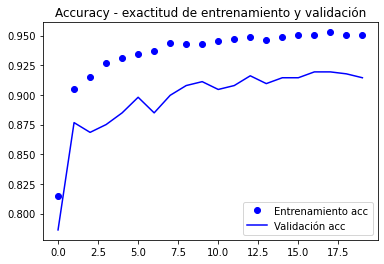

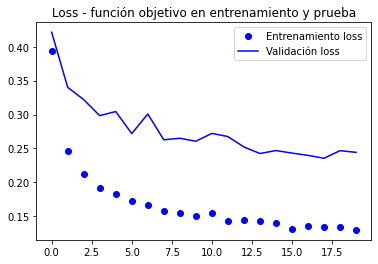

In [ ]:
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

# Otro generador

In [ ]:
model   = None
history = None

In [ ]:
if model != None:
    model.reset_states()   

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)        # modelo base agradado como una capa!
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.3))  # a ver
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
# Otro generador
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers

batch_size = 32

train_datagen = ImageDataGenerator(rescale           = 1./255,
                                   rotation_range    = 40,
                                   width_shift_range = 0.2,
                                   shear_range       = 0.2,
                                   zoom_range        = 0.2,
                                   horizontal_flip   = True,
                                   fill_mode         = 'nearest')                                

# La validación no se aumenta!
test_datagen = ImageDataGenerator(rescale=1./255,
                                    #preprocessing_function=preprocess_input
                                  )

train_generator = train_datagen.flow_from_directory(
                        train_dir,                # directorio con datos de entrenamiento
                        target_size = (150, 150),  # tamaño de la imágenes 
                        batch_size  = batch_size,   
                        # shuffle     = True,
                        class_mode  = 'binary')    # para clasificación binaria

validation_generator = test_datagen.flow_from_directory(
                        test_dir,
                        target_size = (150, 150),
                        batch_size  = batch_size,
                        class_mode  = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Conservo la mejor versión del modelo
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

filepath   = base_dir + 'weights_trial_2.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 2, save_best_only = True)

In [ ]:
model.compile(loss      = 'binary_crossentropy',
              optimizer = keras.optimizers.Nadam(lr=2e-5), #optimizers.RMSprop(lr=2e-5),
              # List of metrics to monitor
              metrics   = ['acc'])

#model.reset_states()

import time
tstart = time.time()


history = model.fit_generator(train_generator,
                              steps_per_epoch  = train_generator.samples // batch_size,      # Aseguro que tenga suficietes datos
                              epochs           = 20,
                              validation_data  = validation_generator,
                              validation_steps = validation_generator.samples // batch_size, # Aseguro que tenga suficietes datos
                              callbacks=[checkpoint],                                        # Logs
                              verbose = 1)                                                   # Veo una línea por época

print('seconds=', time.time()-tstart)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
163/163 [==============================] - 85s 519ms/step - loss: 0.5327 - acc: 0.7004 - val_loss: 0.4029 - val_acc: 0.8405

Epoch 00001: val_acc improved from -inf to 0.84046, saving model to ../content/drive/MyDrive/CIMAT/Segundo Semestre/Aprendizaje Profundo/Tarea3/chest_xray/weights_trial_2.hdf5
Epoch 2/20
163/163 [==============================] - 84s 518ms/step - loss: 0.2650 - acc: 0.9005 - val_loss: 0.3522 - val_acc: 0.8553

Epoch 00002: val_acc improved from 0.84046 to 0.85526, saving model to ../content/drive/MyDrive/CIMAT/Segundo Semestre/Aprendizaje Profundo/Tarea3/chest_xray/weights_trial_2.hdf5
Epoch 3/20
163/163 [==============================] - 84s 518ms/step - loss: 0.2243 - acc: 0.9189 - val_loss: 0.3039 - val_acc: 0.8816

Epoch 00003: val_acc improved from 0.85526 to 0.88158, saving model to ../content/drive/MyDrive/CIMAT/Segundo Semestre/Aprendizaje Profundo/Tarea3/chest_xray/weights_trial_2.hdf5
Epoch 4/20
163/163 [==============================] - 85s 

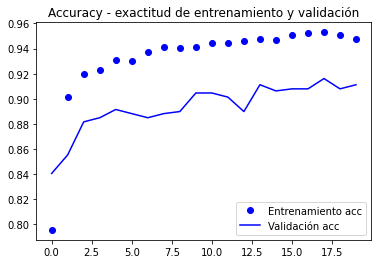

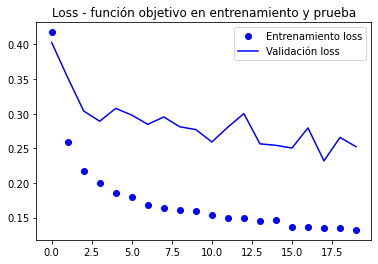

In [ ]:
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

# VGG19

Fue entrenada en más de un millón de imágenes de la base de datos 'imageNet'. Esta red tiene 19 capas profundas y pueden claisificar imágenes entre 1000 categorías. Como resultado, la red se ha enriquecido con las representaciones caranterísticas de un gran rango de imágenes.

En términos generales, la VGG19 es una variante con mas capas de cálculo que la VGG16, por lo tanto mas pesada de almacenar en memoria y en requerimientos de cómputo.

In [ ]:
vgg19 = None

from keras.applications import VGG19
#  Quito capas que no voy a usar
vgg19 = VGG19(weights='imagenet', include_top = True, input_shape=(224, 224, 3))

resumen(vgg19)

#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    input_27         [(None, 224, 224, 3)]    [(None, 224, 224, 3)]             0
1    block1_conv1     (None, 224, 224, 3)      (None, 224, 224, 64)           1792
2    block1_conv2     (None, 224, 224, 64)     (None, 224, 224, 64)          36928
3    block1_pool      (None, 224, 224, 64)     (None, 112, 112, 64)              0
4    block2_conv1     (None, 112, 112, 64)     (None, 112, 112, 128)         73856
5    block2_conv2     (None, 112, 112, 128)    (None, 112, 112, 128)        147584
6    block2_pool      (None, 112, 112, 128)    (None, 56, 56, 128)               0
7    block3_conv1     (None, 56, 56, 128)      (None, 56, 56, 256)          295168
8    block3_conv2     (None, 56, 56, 256)      (None, 56, 56, 256)          590080
9    block3_conv3     (None, 56, 56, 256)      (None, 56, 56, 256)          590080
10   block3_conv4     (None, 56, 56, 256)      (None, 56, 56, 256)          590080
11  

In [ ]:
# Ajustamos VGG16 al tamaño de las imágenes (150, 150)
if vgg19 != None:
    del vgg19
    
from keras.applications import VGG19

conv_base = VGG19(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))
    
resumen(conv_base)  

#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    input_28         [(None, 150, 150, 3)]    [(None, 150, 150, 3)]             0
1    block1_conv1     (None, 150, 150, 3)      (None, 150, 150, 64)           1792
2    block1_conv2     (None, 150, 150, 64)     (None, 150, 150, 64)          36928
3    block1_pool      (None, 150, 150, 64)     (None, 75, 75, 64)                0
4    block2_conv1     (None, 75, 75, 64)       (None, 75, 75, 128)           73856
5    block2_conv2     (None, 75, 75, 128)      (None, 75, 75, 128)          147584
6    block2_pool      (None, 75, 75, 128)      (None, 37, 37, 128)               0
7    block3_conv1     (None, 37, 37, 128)      (None, 37, 37, 256)          295168
8    block3_conv2     (None, 37, 37, 256)      (None, 37, 37, 256)          590080
9    block3_conv3     (None, 37, 37, 256)      (None, 37, 37, 256)          590080
10   block3_conv4     (None, 37, 37, 256)      (None, 37, 37, 256)          590080
11  

In [ ]:
model   = None
history = None

In [ ]:
if model != None:
    model.reset_states()   

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)        # modelo base agradado como una capa!
model.add(layers.Flatten())
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.3))  # a ver
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
resumen(model)

#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    vgg19            (None, 150, 150, 3)      (None, 4, 4, 512)          20024384
1    flatten_19       (None, 4, 4, 512)        (None, 8192)                      0
2    dense_41         (None, 8192)             (None, 256)                 2097408
3    dense_42         (None, 256)              (None, 64)                    16448
4    dense_43         (None, 64)               (None, 1)                        65
__________________________________________________________________________________
Total Parameters :  22138305
Total Trainable Parameters :  22138305
Total No-Trainable Parameters :  0


In [ ]:
print('Número de pesos (matrices) entrenables antes de congelar conv_base : ', len(model.trainable_weights))

Número de pesos (matrices) entrenables antes de congelar conv_base :  38


In [ ]:
conv_base.trainable = False

In [ ]:
print('Número de pesos (matrices) entrenables después de congelar conv_base : ', len(model.trainable_weights))

Número de pesos (matrices) entrenables después de congelar conv_base :  6


In [ ]:
resumen(model)

#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    vgg19            (None, 150, 150, 3)      (None, 4, 4, 512)          20024384
1    flatten_19       (None, 4, 4, 512)        (None, 8192)                      0
2    dense_41         (None, 8192)             (None, 256)                 2097408
3    dense_42         (None, 256)              (None, 64)                    16448
4    dense_43         (None, 64)               (None, 1)                        65
__________________________________________________________________________________
Total Parameters :  22138305
Total Trainable Parameters :  2113921
Total No-Trainable Parameters :  20024384


In [ ]:
# Generador de Mariano

from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers

train_datagen = ImageDataGenerator(#rescale           = 1./255,
                                   preprocessing_function=preprocess_input,
                                   rotation_range    = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range= 0.2,
                                   shear_range       = 0.2,
                                   zoom_range        = 0.2,
                                   horizontal_flip   = True,
                                   fill_mode         = 'constant',  #'nearest')
                                   cval              = 0)

batch_size = 20

# La validación no se aumenta!
test_datagen = ImageDataGenerator(#rescale=1./255)
                                    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
                        train_dir,                # directorio con datos de entrenamiento
                        target_size = (150, 150),  # tamaño de la imágenes 
                        batch_size  = batch_size,   
                        shuffle     = True,
                        class_mode  = 'binary')    # para clasificación binaria

validation_generator = test_datagen.flow_from_directory(
                        test_dir,
                        target_size = (150, 150),
                        batch_size  = batch_size,
                        class_mode  = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Conservo la mejor versión del modelo
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

filepath   = base_dir + 'weights_vgg19.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 2, save_best_only = True)

In [ ]:
model.compile(loss      = 'binary_crossentropy',
              optimizer = keras.optimizers.RMSprop(lr=2e-5),
              # List of metrics to monitor
              metrics   = ['acc'])

#model.reset_states()

import time
tstart = time.time()


history = model.fit_generator(train_generator,
                              steps_per_epoch  = train_generator.samples // batch_size,      # Aseguro que tenga suficietes datos
                              epochs           = 32,
                              validation_data  = validation_generator,
                              validation_steps = validation_generator.samples // batch_size, # Aseguro que tenga suficietes datos
                              callbacks        = [checkpoint],                               # Logs
                              verbose          = 1)                                                   # Veo una línea por época

print('seconds=', time.time()-tstart)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/32
260/260 [==============================] - 88s 334ms/step - loss: 0.9492 - acc: 0.7853 - val_loss: 1.1049 - val_acc: 0.7984

Epoch 00001: val_acc improved from -inf to 0.79839, saving model to ../content/drive/MyDrive/CIMAT/Segundo Semestre/Aprendizaje Profundo/Tarea3/chest_xray/weights_vgg19.hdf5
Epoch 2/32
260/260 [==============================] - 87s 336ms/step - loss: 0.3707 - acc: 0.8873 - val_loss: 0.9276 - val_acc: 0.8371

Epoch 00002: val_acc improved from 0.79839 to 0.83710, saving model to ../content/drive/MyDrive/CIMAT/Segundo Semestre/Aprendizaje Profundo/Tarea3/chest_xray/weights_vgg19.hdf5
Epoch 3/32
260/260 [==============================] - 87s 334ms/step - loss: 0.3049 - acc: 0.9134 - val_loss: 0.8137 - val_acc: 0.8419

Epoch 00003: val_acc improved from 0.83710 to 0.84194, saving model to ../content/drive/MyDrive/CIMAT/Segundo Semestre/Aprendizaje Profundo/Tarea3/chest_xray/weights_vgg19.hdf5
Epoch 4/32
260/260 [==============================] - 87s 335ms/

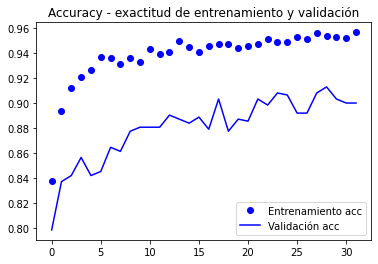

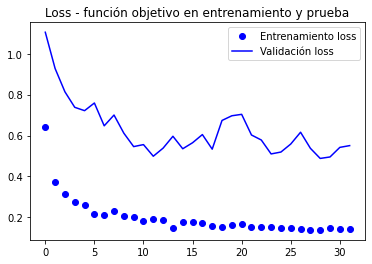

In [ ]:
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

# ResNet50

La redes residuales se inspiran en el hecho biológico de que algunas neuronas se conectan con neuronas en capas no necesariamente contiguas, saltando capas intermedias, y fueron propuesta por Kaiming et al. (2015).

*    ResNet es una red usada como elemento básico en muchas tareas de Visión por Computadora.

*    Fue la red ganadora del la competencia (challenge) ImageNet en 2015.

*    Su mayor impacto se debe a que el paradigma ResNet permitió por primera vez entrenar redes muy profundas (de más de 100 capas); controlando con éxito el problema de Desvanecimiento de Gradiente (Vanishing Gradient).

In [ ]:
resnet50 = None

from keras.applications import ResNet50
conv_base = ResNet50(weights = 'imagenet', include_top = False, input_shape=(150, 150, 3))

In [ ]:
model   = None
history = None

In [ ]:
if model != None:
    model.reset_states()   

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)        # modelo base agradado como una capa!
model.add(layers.Flatten())
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.3))  # a ver
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
resumen(model)
print('Número de pesos (matrices) entrenables antes de congelar conv_base : ', len(model.trainable_weights))

#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    resnet50         (None, 150, 150, 3)      (None, 5, 5, 2048)         23587712
1    flatten_20       (None, 5, 5, 2048)       (None, 51200)                     0
2    dense_44         (None, 51200)            (None, 256)                13107456
3    dense_45         (None, 256)              (None, 64)                    16448
4    dense_46         (None, 64)               (None, 1)                        65
__________________________________________________________________________________
Total Parameters :  36711681
Total Trainable Parameters :  36711681
Total No-Trainable Parameters :  0
Número de pesos (matrices) entrenables antes de congelar conv_base :  218


In [ ]:
conv_base.trainable = False

In [ ]:
print('Número de pesos (matrices) entrenables después de congelar conv_base : ', len(model.trainable_weights))

resumen(model)

Número de pesos (matrices) entrenables después de congelar conv_base :  6
#    Layer Name       Layer Input Shape        Layer Output Shape       Parameters
0    resnet50         (None, 150, 150, 3)      (None, 5, 5, 2048)         23587712
1    flatten_20       (None, 5, 5, 2048)       (None, 51200)                     0
2    dense_44         (None, 51200)            (None, 256)                13107456
3    dense_45         (None, 256)              (None, 64)                    16448
4    dense_46         (None, 64)               (None, 1)                        65
__________________________________________________________________________________
Total Parameters :  36711681
Total Trainable Parameters :  13123969
Total No-Trainable Parameters :  23587712


In [ ]:
# Otro generador / Saltar
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers

batch_size = 32

train_datagen = ImageDataGenerator(rescale           = 1./255,
                                   rotation_range    = 40,
                                   width_shift_range = 0.2,
                                   shear_range       = 0.2,
                                   zoom_range        = 0.2,
                                   horizontal_flip   = True,
                                   fill_mode         = 'nearest')                                

# La validación no se aumenta!
test_datagen = ImageDataGenerator(rescale=1./255,
                                    #preprocessing_function=preprocess_input
                                  )

train_generator = train_datagen.flow_from_directory(
                        train_dir,                # directorio con datos de entrenamiento
                        target_size = (150, 150),  # tamaño de la imágenes 
                        batch_size  = batch_size,   
                        # shuffle     = True,
                        class_mode  = 'binary')    # para clasificación binaria

validation_generator = test_datagen.flow_from_directory(
                        test_dir,
                        target_size = (150, 150),
                        batch_size  = batch_size,
                        class_mode  = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Conservo la mejor versión del modelo
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

filepath   = base_dir + 'weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 2, save_best_only = True)

In [ ]:
model.compile(loss      = 'binary_crossentropy',
              optimizer = keras.optimizers.Nadam(lr=2e-5), #optimizers.RMSprop(lr=2e-5),
              # List of metrics to monitor
              metrics   = ['acc'])

#model.reset_states()

import time
tstart = time.time()


history = model.fit_generator(train_generator,
                              steps_per_epoch  = train_generator.samples // batch_size,      # Aseguro que tenga suficietes datos
                              epochs           = 20,
                              validation_data  = validation_generator,
                              validation_steps = validation_generator.samples // batch_size, # Aseguro que tenga suficietes datos
                              callbacks=[checkpoint],                                        # Logs
                              verbose = 1)                                                   # Veo una línea por época

print('seconds=', time.time()-tstart)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
163/163 [==============================] - 90s 533ms/step - loss: 0.5846 - acc: 0.7077 - val_loss: 0.6084 - val_acc: 0.6250

Epoch 00001: val_acc improved from -inf to 0.62500, saving model to ../content/drive/MyDrive/CIMAT/Segundo Semestre/Aprendizaje Profundo/Tarea3/chest_xray/weights.hdf5
Epoch 2/20
163/163 [==============================] - 86s 530ms/step - loss: 0.5067 - acc: 0.7440 - val_loss: 0.5824 - val_acc: 0.6349

Epoch 00002: val_acc improved from 0.62500 to 0.63487, saving model to ../content/drive/MyDrive/CIMAT/Segundo Semestre/Aprendizaje Profundo/Tarea3/chest_xray/weights.hdf5
Epoch 3/20
163/163 [==============================] - 86s 528ms/step - loss: 0.4704 - acc: 0.7592 - val_loss: 0.5635 - val_acc: 0.6497

Epoch 00003: val_acc improved from 0.63487 to 0.64967, saving model to ../content/drive/MyDrive/CIMAT/Segundo Semestre/Aprendizaje Profundo/Tarea3/chest_xray/weights.hdf5
Epoch 4/20
163/163 [==============================] - 86s 527ms/step - loss: 0.445

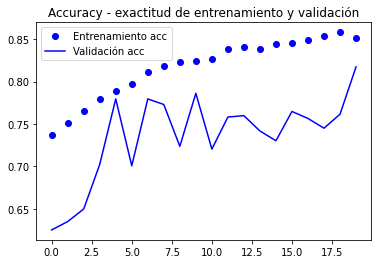

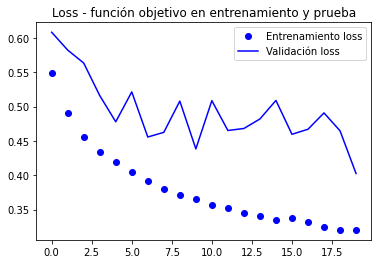

In [ ]:
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

# Conclusiones



1.   Dado que el tamaño del conjunto de validación era de 16, se prefirió usar como validación al conjunto de test (de tamaño 624).
2.   En general, casi todas las arquitecturas llegaron a un accuracy de validación del $0.91$
3.   A la red **VGG16** se le agrearon dos capas (una densa con activación *ReLu* y una neurona al final con activación *sigmoide*) y mostró un mejor desempeño en cuanto a tiempo de ejecución comaprado con el resto de las redes.

4.   La red con **VGG16** pero normalización de datos y la red con **VGG19** necesitaron otra capa densa más que la primera configuración para tener el mismo desempeño.

5.   La red con **ResNet** mostró un *accuracy* por debajo de las demás redes.

6.   En las gráficas de *accuracy* y *loss* la red con **VGG16** mostró mayor suavidad que el resto de las arquitecturas. 

7.   Para todas las gráficas se observó un error cuadrático medio alto entre los datos de entrenamiento y los de validación. Esto podría ser por la falta de dropout entre las capas densas aunque no se observó gran diferencia al agregarlo.



La trasnferencia de conocimiento de redes pre-entrenadas permite a una nueva red entender a priori la inofrmación contenida en un conjunto de entrenamiento dado (como formas, bordes, etc.) Lo anterior permite acelerar el aprendizaje de dicha red dado se observó que el **accuracy** del que se comenzó estaba alrededor de $0.70$. Entonces se procede a ajustar los pesos en base a la nueva información del conjunto de entrenamiento pero guardando el conocimiento dado por el conjunto de la primera red.

Para el caso de las imágenes de **neumonía** se observó un mejor desempeño con la red preentrenada más simple de las tres mostradas **VGG16**.